In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from src.datamodule import MSDataModule
from src.model import MSTransformer

[last_ckpt] = !ls -t1 ./lightning_logs/small/checkpoints/*.ckpt | head -n1
print(last_ckpt)

model = MSTransformer.load_from_checkpoint(last_ckpt)
dm = MSDataModule(**dict(model.hparams))

dm.setup()
model = model.cpu()
model.eval();

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


./lightning_logs/small/checkpoints/epoch=26-step=8855.ckpt


In [4]:
from tqdm import tqdm

embeddings = []
sequences = []
for i, batch in tqdm(enumerate(dm.val_dataloader())):
    z = model.encoder(
        sequence=batch['x'],
        sequence_mask=batch['x_mask']
    )
    z = z.squeeze(1).detach().cpu().numpy()
    embeddings.append(z)
    sequences += batch['sequence']
embeddings = np.concatenate(embeddings,0)

embeddings = pd.DataFrame(embeddings)
embeddings = embeddings.groupby(sequences).mean()
embeddings.shape

288it [04:00,  1.20it/s]


(45348, 64)

In [5]:
def polarity(sequence):
    is_basic = np.array([aa in 'RHK' for aa in sequence])
    polarity = (is_basic * np.arange(len(sequence))).sum() / np.arange(len(sequence)).sum()
    return polarity

import scanpy as sc

adata = sc.AnnData(embeddings)

adata.obs['sequence'] = adata.obs.index
adata.obs['length'] = adata.obs['sequence'].map(len)
adata.obs['first_aa'] = adata.obs['sequence'].str[0]
adata.obs['second_aa'] = adata.obs['sequence'].str[1]
adata.obs['last_aa'] = adata.obs['sequence'].str[-1]
adata.obs['num_basic'] = adata.obs['sequence'].map(lambda s: sum([c in 'RKH' for c in s])).astype(str)
adata.obs['polarity'] = adata.obs['sequence'].map(polarity)

/home/gridsan/mmurphy/.conda/envs/MSPretraining/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


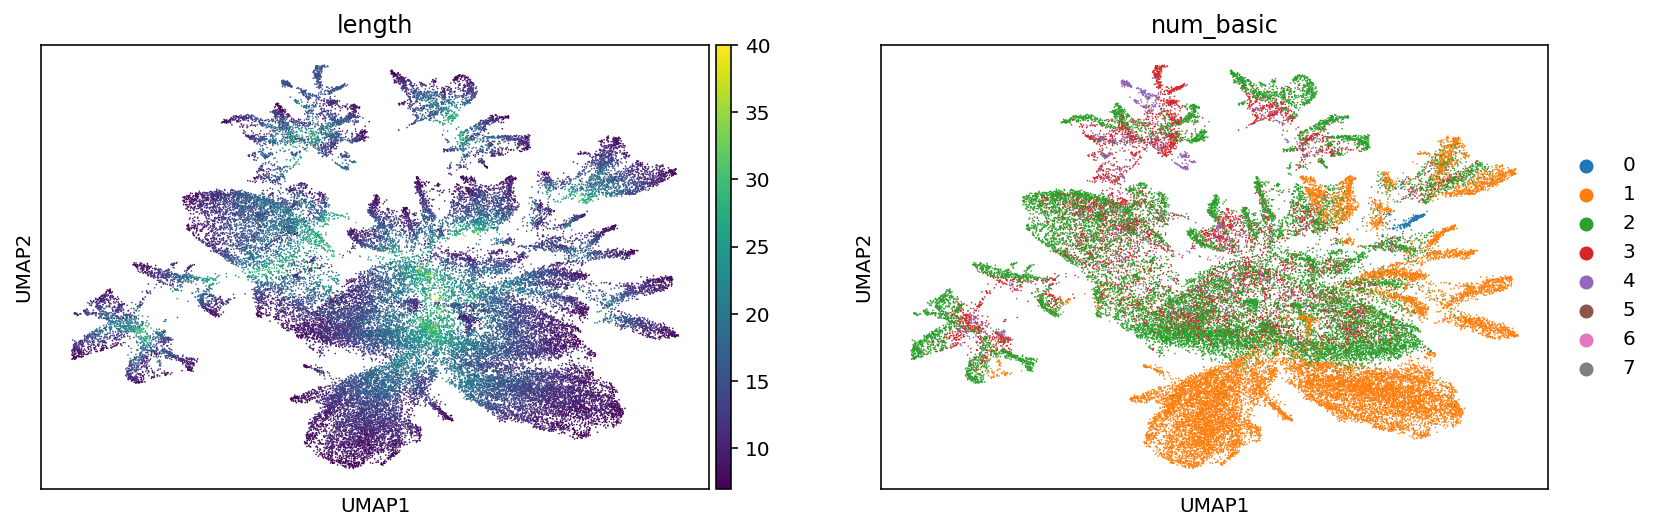

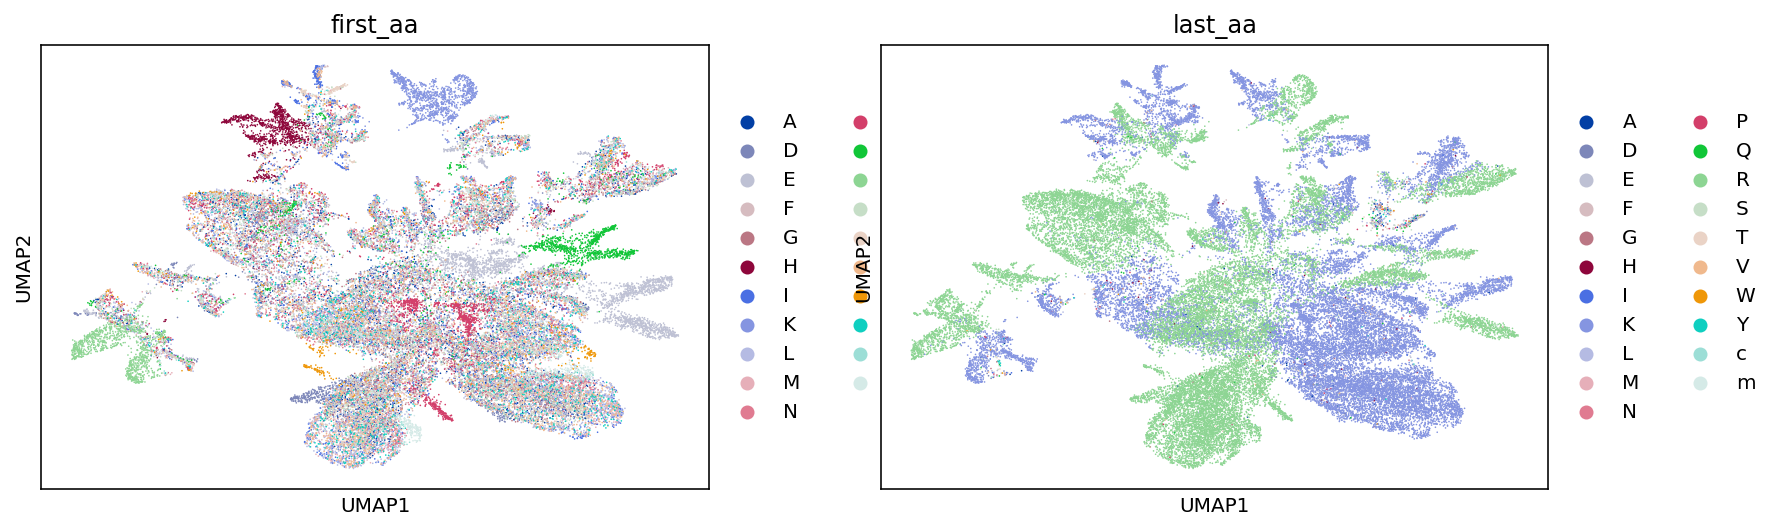

In [6]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, random_state=0)

sc.pl.umap(adata,color=['length','num_basic'])
sc.pl.umap(adata,color=['first_aa','last_aa'])

Next I condition on some of the obvious determinants of structure in the above plots.

In [7]:
# ~50/50 split between C-terminal R and K, since these are tryptic peptides. "Easy to learn?"
adata = adata[adata.obs['last_aa']=='R']
# Use most frequent length.
adata = adata[adata.obs['length']==11]
# Only look at peptides capable of accepting at most 2 protons (most common).
# This should also be easy to learn -- it is a hard constraint on possible fragments.
adata = adata[adata.obs['num_basic']=='2']

In [8]:
sc.tl.pca(adata, random_state=0)
sc.pp.neighbors(adata, random_state=0)
sc.tl.umap(adata, random_state=0)
sc.tl.leiden(adata,resolution=0.2, random_state=0)

adata.obs['pc1'] = adata.obsm['X_pca'][:,0]
adata.obs['pc2'] = adata.obsm['X_pca'][:,1]

adata

AnnData object with n_obs × n_vars = 865 × 64
    obs: 'sequence', 'length', 'first_aa', 'second_aa', 'last_aa', 'num_basic', 'polarity', 'leiden', 'pc1', 'pc2'
    uns: 'pca', 'neighbors', 'umap', 'num_basic_colors', 'first_aa_colors', 'last_aa_colors', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

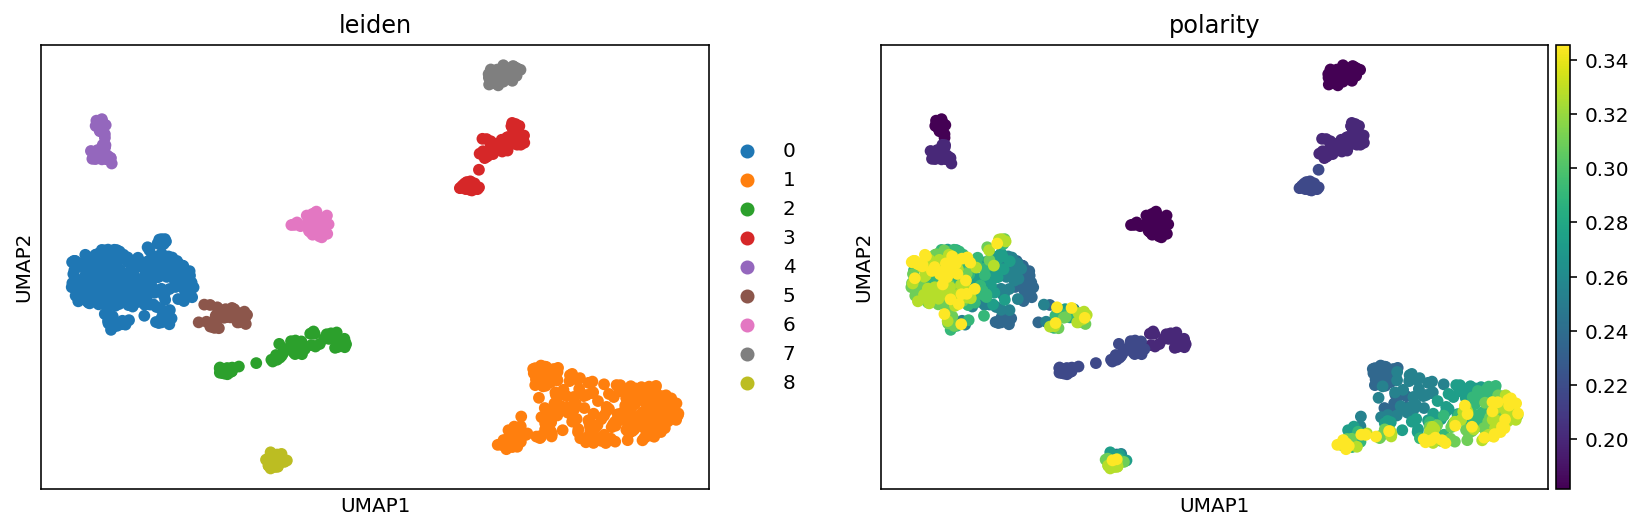

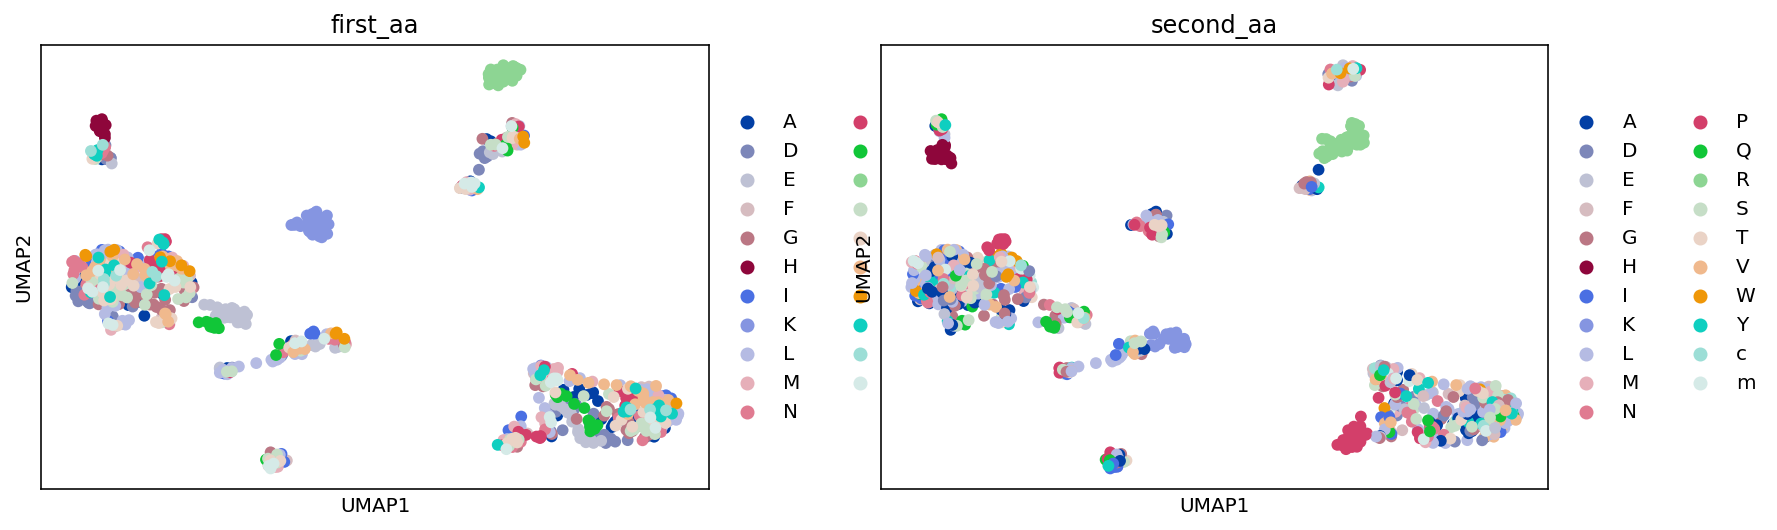

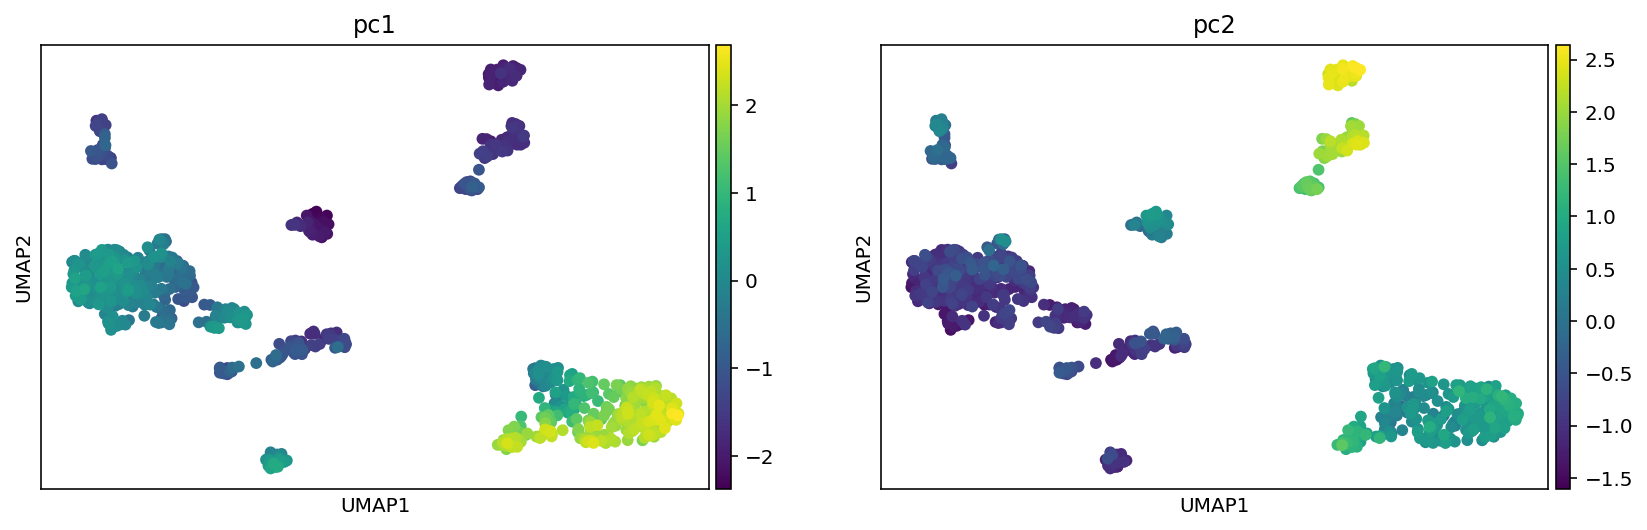

In [9]:
sc.pl.umap(adata,color=['leiden','polarity'])
sc.pl.umap(adata,color=['first_aa','second_aa'])
sc.pl.umap(adata,color=['pc1','pc2'])

PC1 relates to the "polarity" of the sequence, in terms of where the basic residues are situated along the fraction of the length. (This will be biased, as there's always a basic C-terminal residue.)

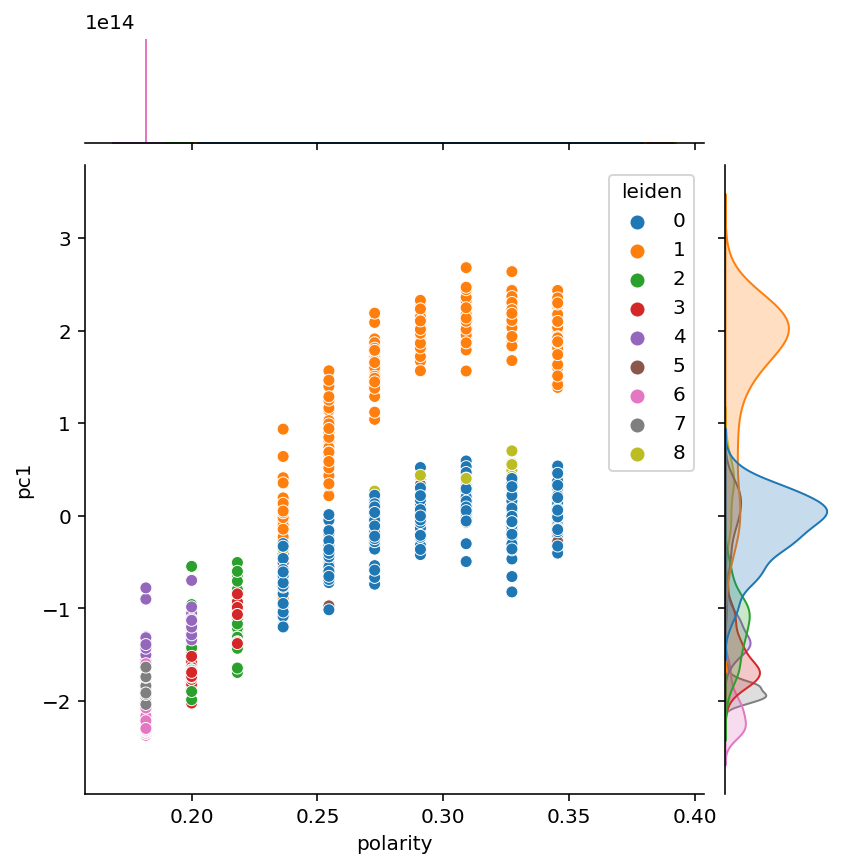

In [10]:
sns.jointplot(data=adata.obs,x='polarity',y='pc1',kind='scatter',hue='leiden')

PC2 relates to the N-terminal AA (specifically, the basicity thereof). This is known to influence fragmentation (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2813199/).

Also: I often notice G tends to behave like an acidic AA, and proline like a basic AA in such figures. Proline is known to interact with basic AAs in fragmentation (https://www.sciencedirect.com/science/article/abs/pii/S1387380611003095).

<AxesSubplot:xlabel='first_aa', ylabel='pc2'>

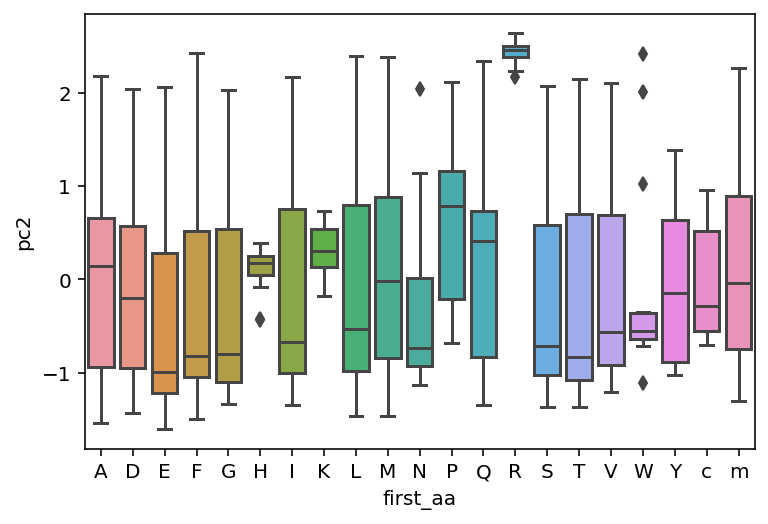

In [11]:
sns.boxplot(data=adata.obs,x='first_aa',y='pc2')

Why do clusters 0 and 1 separate? Let's look at the frequency of AAs in each position. This shows it has to do with composition of the sequence: specifically, whether or not the non-C-terminal basic AA (we condition on having exactly one of these) is arginine or not.

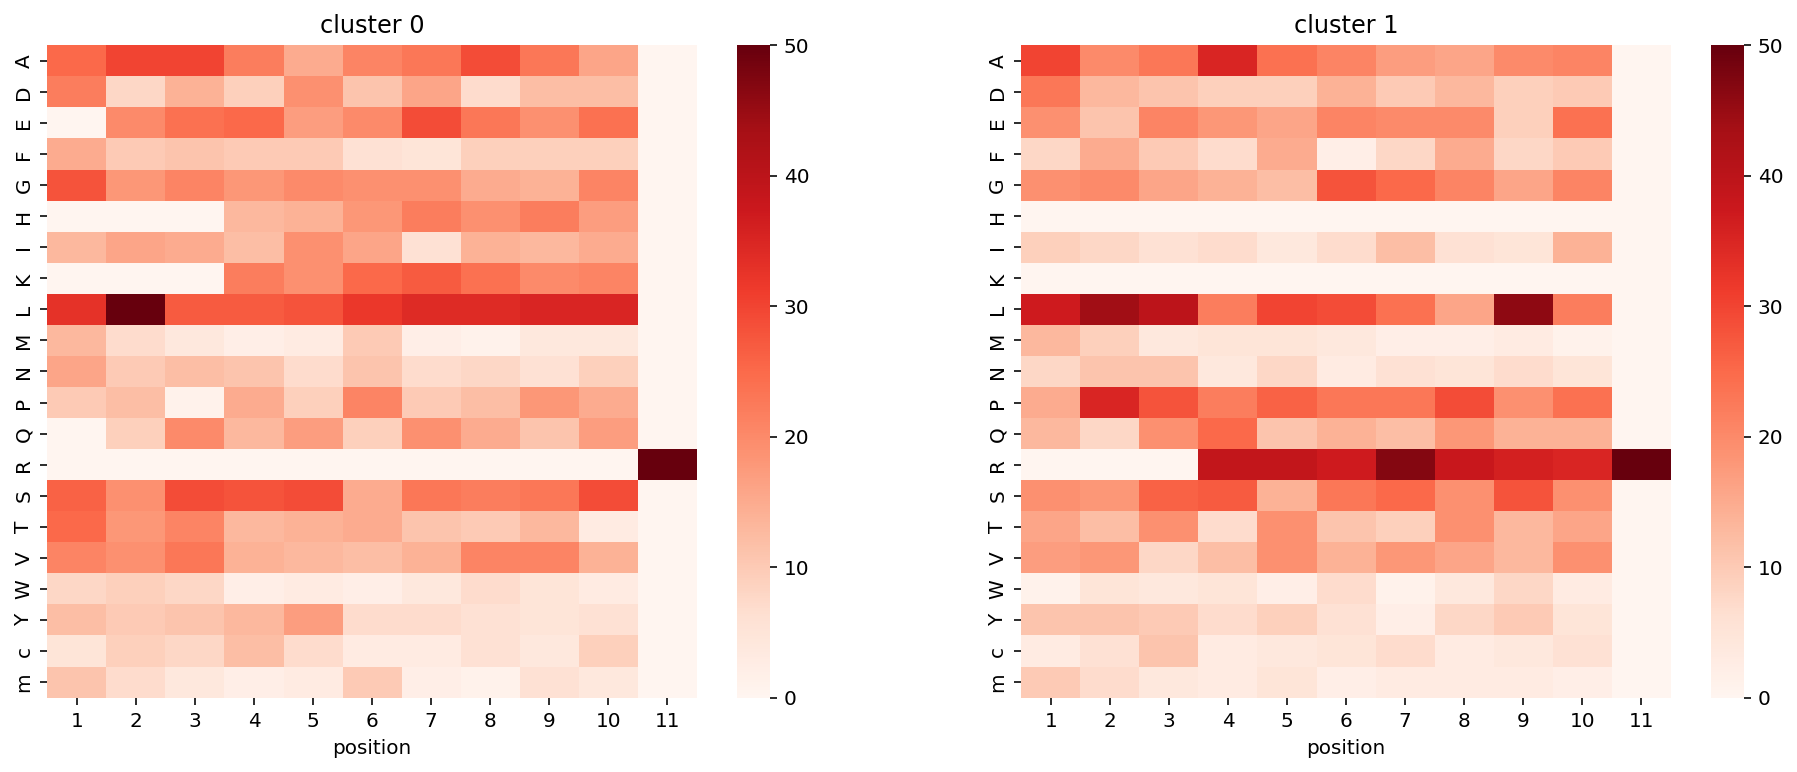

In [12]:
def plot_cluster(cluster, ax, vmax):
    df = pd.DataFrame(adata.obs.query(f'leiden=="{cluster}"')['sequence'].str.split('').tolist()).iloc[:,1:-1]
    df = df.apply(lambda c: c.value_counts())
    df = df.join(pd.Series({aa:0 for aa in model.residues[1:]},name='aa'),how='outer').drop(columns=['aa']).drop(index=['C','O'])
    df = df.fillna(0).astype(int)
    df.columns.name = 'position'
    plt.sca(ax)
    sns.heatmap(df,vmin=0,vmax=vmax,cmap='Reds')
    plt.title(f'cluster {cluster}')

fig,axs = plt.subplots(1,2,figsize=(16,6))
plot_cluster(0, axs[0], 50)
plot_cluster(1, axs[1], 50)

Conclusion: what really seems to determine geometry of the embedding is the identity of the basic residues, and where they are. This is supported by literature (above) and makes a lot of sense: where the proton tends to localize relative to a bond cleavage will be the primary determinant of whether an N-terminal or C-terminal fragment is observed.

The other residues seem mostly irrelevant. This is perhaps not beneficial for tasks where they do matter.

It also suggests that if we don't want to pick up charge information - e.g. if we think it's irrelevant for peptide engineering - we should "symmetrize" our spectra, and only try to predict whether a bond cleaves or not, instead of which side of the cleavage we observe.

In [ ]:
# predicted secondary structure